In [1]:
%cd ../..

f:\DR\Stock-Market-Prediction\src


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from models.cnn_v3.cnn_model import build_model, train_model, save_cnn_model, load_cnn_model
from models.cnn_v3.cnn_normalize import get_cnn_data, get_images_dataset, get_classes_and_files
from utils.chart import config_chart, plot_model_performance, plot_scatter_data, plot_distribution_data, plot_direction_comparison
from constants import SP500_TICKER, NASDAQ_TICKER, DJI_TICKER
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve



---

## For **build_model** function

Конволюционна невронна мрежа (CNN) за класификация на изображения

Структура:
- Input(INPUT_SHAPE) определя входния слой, който получава изображения със зададената форма (256, 256, 4):
    - 256: Широчина на изображението в пиксели.
    - 256: Височина на изображението в пиксели.
    - 4: Брой канали в изображението (вероятно RGBA).
- Conv2D(filters=32, kernel_size=(3, 4), activation='relu'):
    - Използват се три конволюционни слоя за извличане на характеристики:
    - Прилага 32 филтъра с размер (3x4) към входа, извличайки характеристики.
    - Използва ReLU активация за нелинейност.
    - Следват подобни конволюции с намаляващ брой филтри (16 и 8), за да се уловят потенциално по-високо ниво характеристики.
    - Размерът на входните данни се намалява леко след всеки конволюционен слой поради валидиране
- Flatten(): 
    - Преобразува 2D feature maps от конволюционните слоеве в 1D вектор за подаване към плътно свързаните слоеве.
- Dense(units=32, activation='relu'):
    - Създава плътен слой с 32 неврона и ReLU активация.
- Dense(units=5, activation='softmax'):
    - Създава изходния слой с 5 неврона (за 5 класа изображения).
    - softmax активация за разпределение на вероятностите между класовете.


Описание:
- Използва библиотеката tensorflow.keras за изграждане на CNN модела.
- Функцията build_model е дефинирана, за да създаде архитектурата на CNN.
- model = Sequential() инициализира последователен модел, който подрежда слоевете линейно.
- model.compile(...) конфигурира процеса на обучение:
- optimizer=Adam(0.001): Използва оптимизатора Adam с коефициент на обучение 0.001.
- loss='sparse_categorical_crossentropy': Определя функцията на загубата за класификация с множество класове.
- metrics=['accuracy']: Указва метриката за точност, която да се следи по време на обучението.
- Функцията връща компилирания model, готов за обучение върху данните с изображения.

In [3]:
model = build_model()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 253, 32)      1568      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 250, 16)      6160      
                                                                 
 conv2d_2 (Conv2D)           (None, 250, 247, 8)       1544      
                                                                 
 flatten (Flatten)           (None, 494000)            0         
                                                                 
 dense (Dense)               (None, 32)                15808032  
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 15817469 (60.34 MB)
Trainable params: 158


---

## For **train_model** function

Функцията train_model предоставя основен процес за обучение и оценка на CNN модел за класификация на изображения. Тя използва TensorBoard за визуализиране на процеса на обучение и помага за наблюдение на производителността на модела.

Описание:
- Извиква функцията build_model за да създаде CNN модел за класификация на изображения.
- Създава обект TensorBoard callback.
    - Този callback се използва за визуализиране на процеса на обучение в TensorBoard, което е инструмент за наблюдение и отстраняване на грешки при машинно обучение.
    - Callback-ът е конфигуриран да записва резултатите в директорията, определена от константата CNN_V2_LOG_DIRECTORY.
- Използва метода fit на модела за обучение по данните за обучение (x_train и y_train).
    - x_train (np.ndarray): Триизмерен NumPy масив, съдържащ изображения за обучение.
    - y_train (np.ndarray): Едноизмерен NumPy масив, съдържащ целеви класове за изображенията за обучение.
    - Определя се брой епохи на обучение (epochs=10). Епохата е пълен цикъл през всички данни за обучение.
    - Определя се брой стъпки на епоха (steps_per_epoch=100). Стъпката е мини-пакет от данни за обучение.
    - Callback-ът tensorboard_callback се добавя като аргумент към метода fit, за да се активира визуализацията на обучението в TensorBoard.
- След обучението функцията използва метода evaluate на модела за оценка на неговата производителност на данните за тестване (x_test и y_test).
    - x_test (np.ndarray): Триизмерен NumPy масив, съдържащ изображения за тестване.
    - y_test (np.ndarray): Едноизмерен NumPy масив, съдържащ целеви класове за изображенията за тестване.


In [4]:
# nasdaq_train, nasdaq_test, nasdaq_predict= get_cnn_data(NASDAQ_TICKER)
train, test, predict = get_cnn_data(NASDAQ_TICKER)

x_train = train["x"] 
y_train = train["y"]

x_test = test["x"]
y_test = test["y"]

x_predict = predict["x"]
y_predict = predict["y"]


print("Train data:")
print(x_train.shape)
print(y_train.shape)

print("Test data:")
print(x_test.shape)
print(y_test.shape)

print("Predict data:")
print(x_predict.shape)
print(y_predict.shape)

Train data:
(1386, 256, 256, 4)
(1386,)
Test data:
(396, 256, 256, 4)
(396,)
Predict data:
(198, 256, 256, 4)
(198,)


Epoch 1/10


100/100 [==============================] - 26s 248ms/step - loss: 2.4584 - accuracy: 0.5829
Epoch 2/10
100/100 [==============================] - 25s 253ms/step - loss: 0.6279 - accuracy: 0.7350
Epoch 3/10
100/100 [==============================] - 24s 238ms/step - loss: 0.5220 - accuracy: 0.7879
Epoch 4/10
100/100 [==============================] - 30s 302ms/step - loss: 0.8222 - accuracy: 0.7429
Epoch 5/10
100/100 [==============================] - 30s 298ms/step - loss: 0.6767 - accuracy: 0.7436
Epoch 6/10
100/100 [==============================] - 29s 289ms/step - loss: 0.5144 - accuracy: 0.8086
Epoch 7/10
100/100 [==============================] - 26s 255ms/step - loss: 0.4273 - accuracy: 0.8436
Epoch 8/10
100/100 [==============================] - 25s 247ms/step - loss: 0.2699 - accuracy: 0.9007
Epoch 9/10
100/100 [==============================] - 24s 238ms/step - loss: 0.1182 - accuracy: 0.9571
Epoch 10/10
13/13 [==============================] - 1s 87ms/step - los

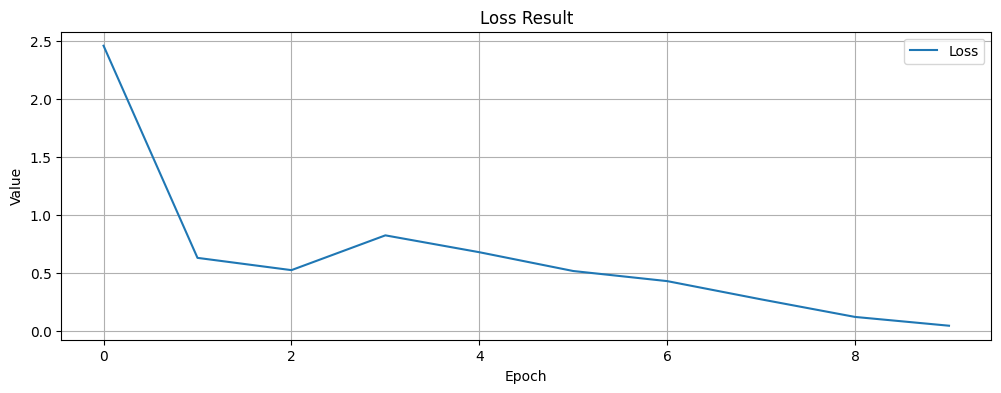

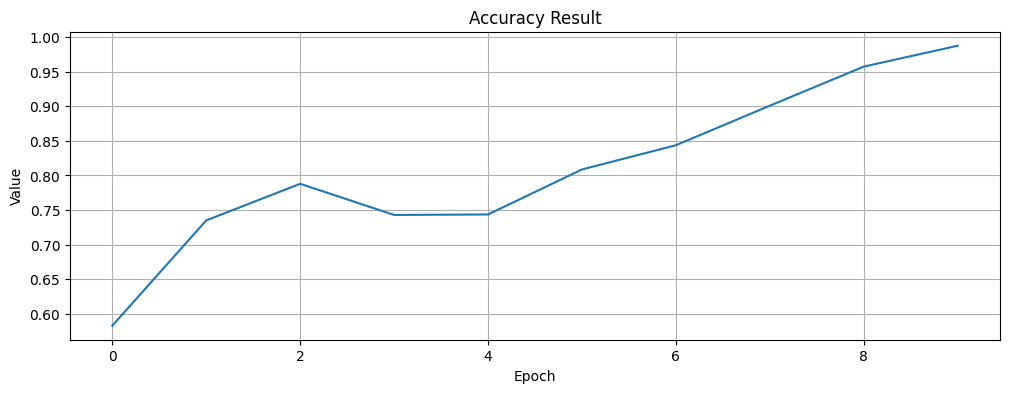

Train result:
Test result:
[1.9867576360702515, 0.631313145160675]


In [5]:
model, fit_result, evaluate_result = train_model(x_train, x_test, y_train, y_test) 

plot_model_performance(fit_result)

print("Train result:")
print(fit_result)

print("Test result:")
print(evaluate_result)

save_cnn_model(model)

In [6]:
latest_train_metrics = [value[-1] for key, value in fit_result.history.items()]

print("Train result:")
print("accuracy, loss")
print(latest_train_metrics)

print("Test result:")
print("loss, accuracy")
print(evaluate_result)

Train result:
accuracy, loss
[0.042386457324028015, 0.9873015880584717]
Test result:
loss, accuracy
[1.9867576360702515, 0.631313145160675]


In [7]:
model = load_cnn_model()

In [13]:
def plotConfusionMatrix(predicted_labels_single, true_labels_single):
    # Convert one-hot encoded labels to single labels
    # true_labels_single = np.argmax(target, axis=1)
    # predicted_labels_single = np.argmax(predictions, axis=1)

    # plt = config_chart("Confusion Matrix")
    # Compute confusion matrix
    cm = confusion_matrix(true_labels_single, predicted_labels_single)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    disp.plot(cmap='Blues', ax=plt.gca())
    plt.title("Confusion Matrix")
    plt.show()
    

def plotCalibration(predictions, target):
    plt = config_chart("Calibration Plot")
    for i in range(5):
        prob_true, prob_pred = calibration_curve(target[:, i], predictions[:, i], n_bins=10)
        plt.plot(prob_pred, prob_true, marker='o', label=f'Class {i}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.show()

44/44 [==============================] - 4s 96ms/step
Accuracy: 0.9877344877344877
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        99
           1       0.97      1.00      0.99       211
           2       1.00      0.93      0.96        69
           3       1.00      1.00      1.00       303
           4       0.99      1.00      0.99       704

    accuracy                           0.99      1386
   macro avg       0.99      0.96      0.98      1386
weighted avg       0.99      0.99      0.99      1386



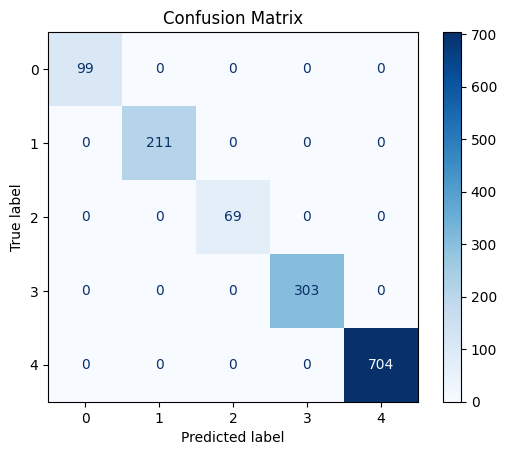

In [17]:
predictions_train = model.predict(x_train)

y_train_classes = y_train
predictions_train_classes = np.argmax(predictions_train, axis=1)


accuracy = accuracy_score(y_train, predictions_train_classes)
print("Accuracy:", accuracy)
report = classification_report(y_train, predictions_train_classes)
print(report)

plotConfusionMatrix(y_train, y_train_classes)
# plotCalibration(predictions_train, y_train)

# predicted_classes = np.argmax(predictions_train, axis=1)

# accuracy = accuracy_score(y_train, predicted_classes)
# print("Accuracy:", accuracy)


13/13 [==============================] - 1s 83ms/step
Accuracy: 0.6313131313131313
              precision    recall  f1-score   support

           0       0.31      0.12      0.18        32
           1       0.65      0.68      0.66        59
           2       0.33      0.13      0.19        23
           3       0.66      0.72      0.69        79
           4       0.65      0.72      0.68       203

    accuracy                           0.63       396
   macro avg       0.52      0.47      0.48       396
weighted avg       0.60      0.63      0.61       396



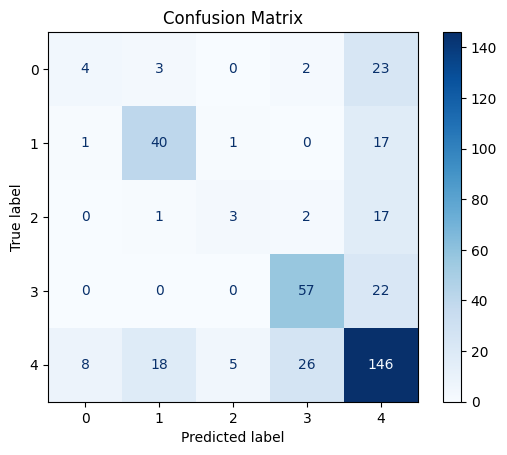

In [19]:
predictions_test = model.predict(x_test)

# y_test_classes = np.argmax(y_test, axis=1)
predictions_test_classes = np.argmax(predictions_test, axis=1)


accuracy = accuracy_score(y_test, predictions_test_classes)
print("Accuracy:", accuracy)
report = classification_report(y_test, predictions_test_classes)
print(report)

plotConfusionMatrix(predictions_test_classes, y_test)

# predicted_classes = np.argmax(predictions_test, axis=1)

# accuracy = accuracy_score(y_test, predicted_classes)
# print("Accuracy:", accuracy)


7/7 [==============================] - 1s 107ms/step
Accuracy: 0.7121212121212122
              precision    recall  f1-score   support

           0       0.50      0.27      0.35        15
           1       0.71      0.78      0.75        32
           2       0.57      0.40      0.47        10
           3       0.74      0.74      0.74        38
           4       0.73      0.78      0.75       103

    accuracy                           0.71       198
   macro avg       0.65      0.59      0.61       198
weighted avg       0.70      0.71      0.70       198



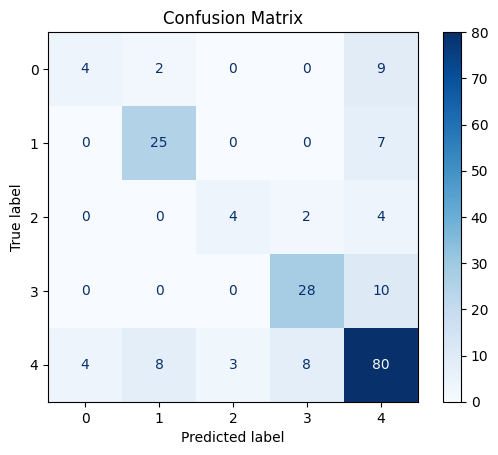

In [20]:
predictions = model.predict(x_predict)

# y_predictions_classes = np.argmax(y_predict, axis=1)
predictions_classes = np.argmax(predictions, axis=1)


accuracy = accuracy_score(y_predict, predictions_classes)
print("Accuracy:", accuracy)
report = classification_report(y_predict, predictions_classes)
print(report)

plotConfusionMatrix(predictions_classes, y_predict)

# predicted_classes = np.argmax(predictions, axis=1)

# accuracy = accuracy_score(y_predict, predicted_classes)
# print("Accuracy:", accuracy)


['bearish_reverse' 'bearish_trend' 'bullish_reverse' 'bullish_trend'
 'neutral']
[2.8329984e-07 9.9973899e-01 3.0068359e-06 3.3240427e-15 2.5774643e-04]
Actual Result: bearish_trend
Predicted Result: bearish_trend


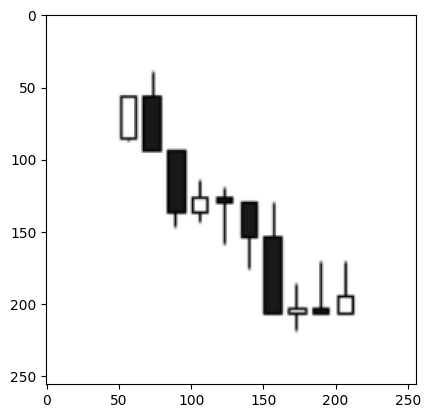

In [11]:
index = 40

classes, _ = get_classes_and_files()

print(classes)
print(predictions[index])
print("Actual Result:", classes[y_predict[index]])
print("Predicted Result:", classes[predicted_classes[index]])

img = predicted_classes[index]
plt.imshow(x_predict[index])